In [21]:
import pandas as pd

In [22]:
df = pd.read_csv("../data/marketing_AB.csv")

In [23]:
def basic_eda_summary(df):
    """
    Prints a basic exploratory data analysis summary of a DataFrame.
    Includes shape, column info, missing values, data types, and simple statistics.
    Visualization is excluded by design.
    """

    print("=" * 50)
    print("BASIC EDA SUMMARY")
    print("=" * 50)

    # Shape of the DataFrame
    print("\n[1] Shape of the DataFrame:")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

    # Column names
    print("\n[2] Column Names:")
    print(df.columns.tolist())

    # Data types and non-null counts
    print("\n[3] Data Types and Non-Null Counts:")
    print(df.info(memory_usage=False, verbose=True))

    # Missing values per column
    print("\n[4] Missing Values (per column):")
    missing = df.isna().sum()
    print(missing[missing > 0] if missing.any() else "No missing values.")

    # Number of unique values per column
    print("\n[5] Number of Unique Values per Column:")
    print(df.nunique())

    # Basic statistics for numeric columns
    print("\n[6] Summary Statistics (numeric columns):")
    print(df.describe())

    print("\nBasic EDA summary complete.")

def detect_categorical_candidates(df, threshold_ratio=0.05, max_display_values=5):
    """
    Detects likely categorical features in a DataFrame, including:
    - object dtype with low cardinality
    - numeric columns with small unique value count relative to total rows
    """

    print("Categorical Feature Candidates\n" + "=" * 40)

    total_rows = len(df)

    for col in df.columns:
        unique_vals = df[col].nunique(dropna=False)
        dtype = df[col].dtype

        # Heuristic 1: object or category dtype with low cardinality
        if dtype == 'object' or dtype.name == 'category':
            print(f"- {col} [type: {dtype}, {unique_vals} unique] — likely categorical (textual)")
            sample = df[col].dropna().unique()[:max_display_values]
            print(f"  sample values: {sample} ...\n")

        # Heuristic 2: numeric column with low cardinality
        elif unique_vals < total_rows * threshold_ratio:
            print(f"- {col} [type: {dtype}, {unique_vals} unique] — possibly categorical (numeric)")
            sample = df[col].dropna().unique()[:max_display_values]
            print(f"  sample values: {sample} ...\n")

    print("Categorical detection complete.\n")


In [24]:
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [25]:
detect_categorical_candidates(df,threshold_ratio=0.001)
basic_eda_summary(df)

Categorical Feature Candidates
- test group [type: object, 2 unique] — likely categorical (textual)
  sample values: ['ad' 'psa'] ...

- converted [type: bool, 2 unique] — possibly categorical (numeric)
  sample values: [False  True] ...

- most ads day [type: object, 7 unique] — likely categorical (textual)
  sample values: ['Monday' 'Tuesday' 'Friday' 'Saturday' 'Wednesday'] ...

- most ads hour [type: int64, 24 unique] — possibly categorical (numeric)
  sample values: [20 22 18 10 14] ...

Categorical detection complete.

BASIC EDA SUMMARY

[1] Shape of the DataFrame:
Rows: 588101, Columns: 7

[2] Column Names:
['Unnamed: 0', 'user id', 'test group', 'converted', 'total ads', 'most ads day', 'most ads hour']

[3] Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 


In [4]:
df = df.drop(columns=['Unnamed: 0'])

# パーセンタイル境界を計算
q33 = df['total ads'].quantile(0.33)
q66 = df['total ads'].quantile(0.66)

# カテゴリを追加（ラベルは medium にしてます）
def make_classify_ads(x):
    if x <= q33:
        return 'light'
    elif x <= q66:
        return 'medium'
    else:
        return 'heavy'

df['user_segment'] = df['total ads'].apply(make_classify_ads)


In [8]:
df['day_type'] = df['most ads day'].apply(lambda x: 'weekend' if x in ['Saturday', 'Sunday'] else 'weekday')

def classify_hour(x):
    if 5 <= x < 12:
        return 'morning'
    elif 12 <= x < 18:
        return 'afternoon'
    else:
        return 'evening'

df['time_segment'] = df['most ads hour'].apply(classify_hour)



In [5]:
group_ad = df[df['test group'] == 'ad']['converted'].astype(float).dropna()
group_psa = df[df['test group'] == 'psa']['converted'].astype(float).dropna()


In [11]:
df.groupby(['day_type', 'test group'])['converted'].mean()


day_type  test group
weekday   ad            0.026564
          psa           0.018004
weekend   ad            0.022999
          psa           0.017407
Name: converted, dtype: float64

In [10]:
df.groupby(['time_segment', 'test group'])['converted'].mean()


time_segment  test group
afternoon     ad            0.027668
              psa           0.020158
evening       ad            0.025978
              psa           0.018659
morning       ad            0.021163
              psa           0.012522
Name: converted, dtype: float64

In [6]:
df['user_segment'].value_counts()


user_segment
light     201232
heavy     199842
medium    187027
Name: count, dtype: int64

In [9]:
df.groupby(['time_segment', 'test group'])['converted'].mean()


time_segment  test group
afternoon     ad            0.027668
              psa           0.020158
evening       ad            0.025978
              psa           0.018659
morning       ad            0.021163
              psa           0.012522
Name: converted, dtype: float64

In [7]:
df.groupby(['user_segment', 'test group'])['converted'].mean()


user_segment  test group
heavy         ad            0.065577
              psa           0.042109
light         ad            0.002579
              psa           0.003033
medium        ad            0.007496
              psa           0.007972
Name: converted, dtype: float64

In [30]:
df.info()
df['test group'].value_counts()
df['converted'].mean()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
 6   user_segment   588101 non-null  object
dtypes: bool(1), int64(3), object(3)
memory usage: 27.5+ MB


np.float64(0.02523886203220195)

In [31]:
df.groupby('test group')['converted'].mean()


test group
ad     0.025547
psa    0.017854
Name: converted, dtype: float64

In [32]:
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour,user_segment
0,1069124,ad,False,130,Monday,20,heavy
1,1119715,ad,False,93,Tuesday,22,heavy
2,1144181,ad,False,21,Tuesday,18,heavy
3,1435133,ad,False,355,Tuesday,10,heavy
4,1015700,ad,False,276,Friday,14,heavy


In [12]:
from scipy.stats import ttest_ind

for seg in ['light', 'medium']:
    group_ad = df[(df['user_segment'] == seg) & (df['test group'] == 'ad')]['converted'].astype(float)
    group_psa = df[(df['user_segment'] == seg) & (df['test group'] == 'psa')]['converted'].astype(float)

    t_stat, p_value = ttest_ind(group_ad, group_psa, equal_var=False)
    print(f"{seg.capitalize()} Users → t = {t_stat:.4f}, p = {p_value:.4f}")


Light Users → t = -0.7637, p = 0.4450
Medium Users → t = -0.4252, p = 0.6707


# Welch's t-test

In [11]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(group_ad, group_psa, equal_var=False)

print(f"T統計量 = {t_stat:.4f}")
print(f"p値 = {p_value:.6f}")

T統計量 = 8.6572
p値 = 0.000000


In [12]:
import numpy as np

# 各群の平均と標準偏差
mean_ad = group_ad.mean()
mean_psa = group_psa.mean()
std_ad = group_ad.std()
std_psa = group_psa.std()
n_ad = group_ad.shape[0]
n_psa = group_psa.shape[0]

# Welch用の効果量（標準偏差の重み付き平均）
s = np.sqrt(((std_ad ** 2) + (std_psa ** 2)) / 2)

# Cohen's d 計算
cohen_d = (mean_ad - mean_psa) / s

print(f"Cohen's d = {cohen_d:.4f}")


Cohen's d = 0.0528


# ベイズ

In [13]:
# 成功数（converted == True）と全体数
success_ad = group_ad.sum()
total_ad = len(group_ad)

success_psa = group_psa.sum()
total_psa = len(group_psa)


In [14]:
import numpy as np

# ベータ分布（事後分布：成功+1, 失敗+1）
samples_ad = np.random.beta(success_ad + 1, total_ad - success_ad + 1, 10000)
samples_psa = np.random.beta(success_psa + 1, total_psa - success_psa + 1, 10000)


In [15]:
prob_ad_better = (samples_ad > samples_psa).mean()

print(f"adがpsaより高いCVRである確率 = {prob_ad_better:.4f}")


adがpsaより高いCVRである確率 = 1.0000


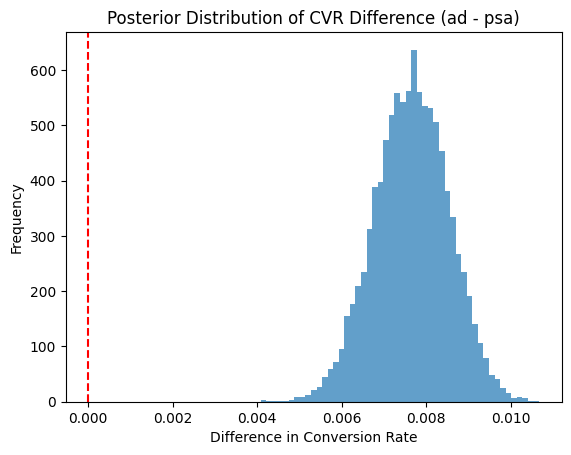

In [18]:
import matplotlib.pyplot as plt

diff = samples_ad - samples_psa

plt.hist(diff, bins=50, alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Posterior Distribution of CVR Difference (ad - psa)")
plt.xlabel("Difference in Conversion Rate")
plt.ylabel("Frequency")
plt.show()


In [19]:
# 95%信用区間
lower, upper = np.percentile(diff, [2.5, 97.5])
mean_diff = diff.mean()

print(f"Mean CVR difference: {mean_diff:.4%}")
print(f"95% credible interval: [{lower:.4%}, {upper:.4%}]")


Mean CVR difference: 0.7649%
95% credible interval: [0.5909%, 0.9319%]
